# Anvendt KI og ML: Maskinlæringsprosessen
Velkommen til denne notebooken som inngår i Høyskolen Kristianias emne «Anvendt kunstig intelligens og maskinlæring», modul 1, «Dataanalyse og maskinlæring som prosess».

## Hvordan du bruker denne notebooken 
Dette er en Jupyter notebook med tekst og Python-kode som du kjører ved å trykke shift-enter. Hensikten er å bli kjent med relevante konsepter i praksis, ikke nødvendigvis å forstå alle detaljer i koden. Ta deg god tid til å lese teksten, se gjennom koden, kjøre kodecellene (pass på riktig rekkefølge), studere resultatene, og tenke gjennom hva vi gjør, hvorfor og hvordan.

Underveis i teksten vil du finne referanser til Canvas-oppgaver _i kursiv_. Gå til Canvas og besvar spørsmålene der før du går videre i notebooken.

## Problemstilling: Utforske data til bruk for å predikere mosjonsløp
I denne notebooken skal vi se hvordan vi kan utforske dataene, finne problemer med datakvaliteten, og se hvordan disse vil påvirke en modell.

In [1]:
# Vi starter med å importere alle programvarebibliotek vi vil bruke
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import math

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler

np.random.seed(10)
random.seed(30)

In [2]:
# En liten test for å sjekke at vi faktisk kjører i riktig Anaconda-environment
import sys
print(sys.executable)

C:\Users\16018\AppData\Local\anaconda3\envs\kristiania\python.exe


In [3]:
# Noen hjelpefunksjoner. Du må kjøre disse cellene.
def make_histogram(data, variable, binwidth, lower_lim=None, upper_lim=None):
    if upper_lim == None:
        upper_lim = data[variable].max()
    if lower_lim == None:
        lower_lim = data[variable].min()
    bins=np.arange(lower_lim, upper_lim + binwidth, binwidth)
    plt.hist(data[variable],bins=bins,edgecolor = 'black',alpha=0.75,range = [data[variable].min(),upper_lim])
    plt.ylabel("antall")
    plt.xlabel(variable)

In [4]:
def make_scatter_plot(data, para1, para2, logx=False, logy=False):
    plt.plot(data[para1], data[para2], '*', alpha=0.1)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale('log')
    plt.xlabel(para1)
    plt.ylabel(para2)

In [5]:
def corr_heatmap(df, figsize=(10, 10)):
    _, axs = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True, ax=axs)
    ax.set_title('Correlation matrix')
    return ax

## Utforske dataene
Her skal du selv utforske dataene for å få et overblikk. Som et minimum bør man sjekke maks-/min-verdier, antall verdier for kategoriske variabler, distribusjonen til de forskjellige variablene, og om det er noen korrelasjon mellom variablene. Vi har laget tre hjelpefunksjoner for å lage histogrammer, scatterplots og en heatmap for korrelasjoner. Nedenfor vises hvordan disse brukes for noen av variablene.

Din jobb er å utforske hele datasettet og se om noen data bør ekskluderes før vi kan bruke datasettet til maskinlæring.

In [6]:
# Ved hjelp av Pandas-biblioteket leser vi inn datasettet fra fil
data = pd.read_csv("data/mosjonsløp.csv")

In [7]:
# Vi ser på de fem øverste radene av datasettet
data.head()

,tid,trening per uke,alder,klasse,løpsted
0,0:40:16,2,45,herre,Oslo
1,0:46:25,8,19,dame,Tromsø
2,0:35:21,5,48,herre,Tromsø
3,0:40:33,11,47,dame,Lillehammer
4,0:52:34,5,65,herre,Tromsø


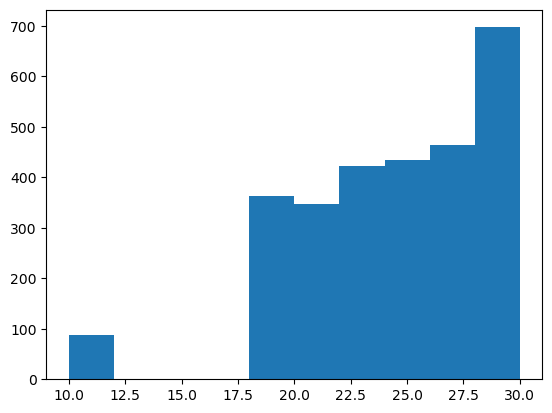

In [8]:
plt.hist(data["alder"],range=[10,30]);

_Oppgave: Svar på flervalgsspørsmålene 1 og 2 (vist nedenfor) i Canvas, og reflekter litt rundt svarene._

1. _Før du har begynt å se på dataene, kan du si noe om hvorvidt de er representative eller har bias bare ut fra informasjonen du har fått om dataene?_
2. _Når vi nå trener en modell på disse dataene, hvilken problemstilling er det vi faktisk svarer på?_

In [9]:
# Vi forenkler navnet på variabelen for å gjøre det litt enklere for oss selv
data.rename(columns={"trening per uke":"trening"},inplace=True)

In [10]:
# Her trekker vi ut antall minutter fra tiden som vi
# får oppgitt i minutter:sekunder. Dette er et eksempel på feature
# engineering som vi må gjøre før vi kan begynne å utforske dataene.
data["tid"] = pd.to_timedelta(
    data["tid"]).apply(lambda x: x.total_seconds()/60.0)

In [11]:
# Se på de fem øverste radene av dataene
data.head()

,tid,trening,alder,klasse,løpsted
0,40.266667,2,45,herre,Oslo
1,46.416667,8,19,dame,Tromsø
2,35.350000,5,48,herre,Tromsø
3,40.550000,11,47,dame,Lillehammer
4,52.566667,5,65,herre,Tromsø


In [12]:
# Hvor mye data har vi?
data.shape

(10000, 5)

In [36]:
# For de numeriske variablene kan du finne gjennomsnittet, maks og min.
# Sjekk om du får realistiske verdier for alle variablene. Du må fra "tid"
# til de andre numeriske variablene for å få til dette.
print("Gjennomsnitt", data["tid"].mean())
print("Maks", data["tid"].max())
print("Min", data["tid"].min())

Gjennomsnitt 48.643071666666664
Maks 120.0
Min 11.216666666666667


In [25]:
# For de kategoriske variablene kan du telle antallet du har i hver kategori.
# Sjekk også her at du får realistiske resultater for alle de kategoriske variablene.
# Du må endre fra "klasse" til de andre kategoriske variablene for å få til dette.
from IPython.display import display
display(data["løpsted"].value_counts())
display(data["klasse"].value_counts())

#data["løpsted"].value_counts()
#data["klasse"].value_counts()

løpsted
Tromsø          1727
Lillehammer     1694
Bergen          1661
Kristiansand    1658
Grimstad        1652
Oslo            1608
Name: count, dtype: int64

klasse
herre    5057
dame     4943
Name: count, dtype: int64

In [40]:
print(data["alder"].value_counts())
#hva er laveste alder? 
print("lavest", data["alder"].min()) 
#høyeste? 
print("høyeste", data["alder"].max())
#snitt?
print("snitt", data["alder"].mean())
#median?
import statistics
print("median", statistics.median(data["alder"]))


alder
28    255
40    252
27    243
44    242
41    237
     ... 
83      8
88      6
84      5
90      3
89      1
Name: count, Length: 74, dtype: int64
lavest 10
høyeste 90
snitt 41.853
median 40.0


Du skal nå bruke hjelpefunksjonen `make_histogram()` for å se på histogrammer over de numeriske variablene.

None

None

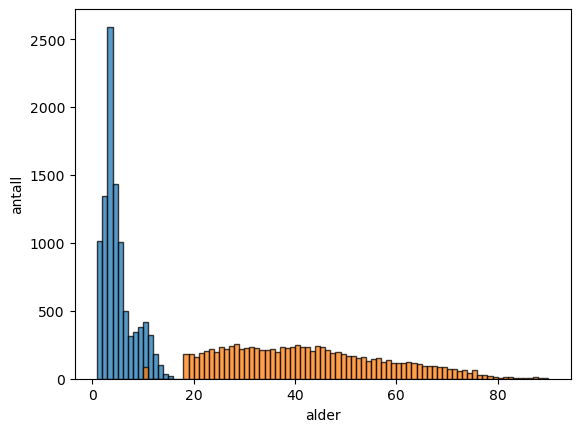

In [22]:
# Bruk av hjelpefunksjonen demonstreres nedenfor.
# Det tredje argumentet er "bin"-bredden, og du kan også sette de frivillige
# argumentene lower_lim og upper_lim.
# Ser du her noe som ikke var så lett å se bare fra gjennomsnittet?
display(make_histogram(data, "trening", 1))
#display(make_histogram(data, "alder", 1))

_Oppgave: Svar på flervalgsspørsmålene 3–6 (vist nedenfor) i Canvas._

3. _Hvor mange datapunkter har vi, og hvor mange løpere?_ 5 variable og 10.000 løpere
4. _Sjekk, for hver av de kategoriske variablene, hvor mange eksempler du har i hver kategori. Ser du noe rart?_ På løpestedene fordeler løperne seg omtrent likt
5. _Er det noe rart med fordelingen av alder i dataene?_
6. _Hva er rart med fordelingen av tider? Hvor fort kan du tenke deg at det er mulig å løpe 5 km?_

In [23]:
# Hjelpefunksjonen corr_heatmap gir et grafisk bilde på korrelasjonene.
# Den bruker Pearsons korrelasjonskoeffisient.
corr_heatmap(data.corr())

ValueError: could not convert string to float: 'herre'

Dersom du vil se nærmere på noen av korrelasjonene, er det lurt å lage scatterplot.

Prøv å lage scatterplots for alle  mulige kombinasjoner av variablene for å få et best mulig bilde av korrelasjonene.

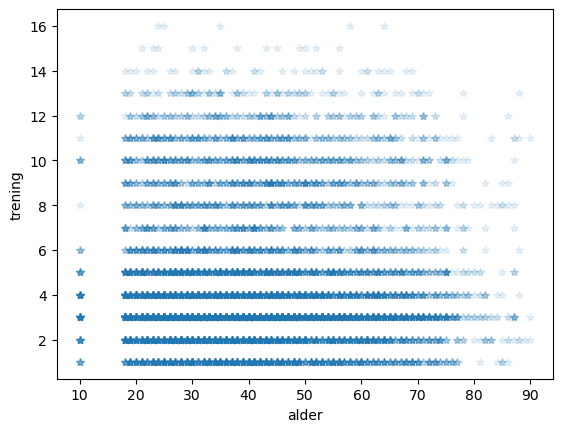

In [17]:
# Demonstrasjon av hjelpefunksjonen:
make_scatter_plot(data, "alder", "trening")

_Oppgave: Svar på flervalgsspørsmålene 7 og 8 (vist nedenfor) i Canvas._

7. _Bruk hjelpefunksjonen til å se på korrelasjoner. Prøv å se på korrelasjonen før og etter at du har tatt vekk løperne som løp på 120 minutter, og løperne fra Lillehammer, siden vi nå kan anta at disse datapunktene ikke reflekterer den reelle løpstiden. Du kan ta vekk disse dataene med denne koden:_
```
data=data[data["tid"]!=120] 
data=data[data["løpsted"]!="Lillehammer"]
```
_Hva ser du?_
8. _Prøv å lage et scatterplot for å studere korrelasjonene litt grundigere. Hva finner du ut som ikke var lett å se kun fra korrelasjonskoeffisientene?_

## Trene modellen
Etter at vi har utforsket dataene, kan vi begynne med selve modelleringsfasen. Vi skal rense dataene på bakgrunn av det vi fant ut under utforskningen, preprosessere dem, og så trene modellen.

### Fjerne det som opplagt er feil
Under utforskningen av dataene har vi funnet at dataene fra Lillehammer virker å være urealistiske. Å løpe på 120 minutter er antageligvis en default verdi, og 10-åringer deltok antageligvis ikke i løpet på vanlig måte. Derfor fjerner vi disse datapunktene før vi starter.

In [18]:
data = data[data["tid"] != 120]
data = data[data["alder"] != 10]
data = data[data["løpsted"] != "Lillehammer"]

### Oppsplitting og preprosessering av dataene
Her er det viktig å huske på at vi skal splitte dataene i trenings-, validerings- og testdata. Først henter vi ut testdataene, som vi ikke skal se på før alle valg for modellen er tatt (hvilken modell, hva slags preprosessering, hvilke features osv.). Deretter kan vi splitte de dataene vi har igjen, i trenings- og valideringsdata.

### Gjøre alt om til tall
En maskinlæringsalgoritme kan kun lese tall. Derfor starter vi med å gjøre om alle kategoriske variabler til tall. Siden de kategoriske variablene vi har (klasse og løpssted) ikke har noen naturlig rangering, velger vi å gjøre en-hot-koding (one-hot encoding).

In [19]:
# Her bruker vi en-hot-koding for å gjøre om de kategoriske variablene
# til tall
data = pd.get_dummies(data, drop_first=True)

### Dele i treningsdata, evalueringsdata og testdata

In [20]:
# Testdataene skal vi ikke se på før helt til slutt
test_data = data.sample(frac=0.2, random_state=2)

# Vi jobber så videre med datasettet der vi har tatt vekk testdataene
mydata = data.drop(test_data.index).reset_index(drop=True)

In [21]:
# Vi deler datasettet der vi har tatt vekk testdataene inn i treningsdata og evalueringsdata
X_train, X_eval, y_train, y_eval = train_test_split(
    mydata.drop(columns="tid"), mydata["tid"], test_size=0.20, random_state=10)

### Skalering av dataene
Merk her hvordan vi skalerer med treningsdataene og bruker skaleringen fra treningsdataene på valideringsdataene.

In [22]:
# Her lager vi en min/max scalar ved hjelp av treningsdataene
scalerX = MinMaxScaler()
scalerX.fit(X_train)
# Både for treningsdataene og evalueringsdataene skalerer vi med min/max fra treningsdataene
X_train = scalerX.transform(X_train)
X_eval = scalerX.transform(X_eval)

### Trene en enkel lineær modell
Vi vet hva vi ønsker å predikere (løpstiden), altså kjenner vi den avhengige variabelen. Det vil si at vi har et veiledet problem. Den avhengige variabelen er numerisk, og derfor skal vi trene en regresjonsmodell.

Som et første forsøk trener vi en enkel lineær regresjonsmodell.

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
# Så kan vi regne ut RMSE på valideringsdataene
np.sqrt(mean_squared_error(y_eval, model.predict(X_eval)))

5.906466927501045

_Oppgave: Svar på flervalgsspørsmålene 9 og 10 (vist nedenfor) i Canvas._

9. _Prøv å trene en enkel lineær modell. Husk å dele i treningsdata, evalueringsdata og testdata. Gjør den nødvendige preprosesseringen av dataene. Regn ut RMSE på evalueringsdataene. Gjør dette med og uten å fjerne dataene som vi antar er feil. Hva blir resultatet?_
10. _Nå når vi har trent modellen og testet den på evalueringsdataene, bør vi da med en gang sjekke hvor godt den fungerer på testdataene?_


_Oppgave: Svar på fritekstspørsmålene 11–13 (vist nedenfor) i Canvas._

11. _I denne notebooken har vi helt klart en bias i dataene, siden dataene kun består av personer som har valgt å stille opp i et mosjonsløp. Men vi spør også løperne hvor mange timer i uken de trener. Vil ikke det spørsmålet ta vekk biasen, slik at modellen kan brukes til å predikere hvor fort en hvilken som helst person kommer til å løpe 5 km? Hva tenker du rundt dette?_
12. _Da vi utforsket dataene, så vi at noen løp raskere enn verdensrekorden, og det viste seg at alle de raske tidene kom fra løpet på Lillehammer. Hva bør vi gjøre i denne situasjonen og med disse dataene?_
13. _Dataene om antall treningstimer er samlet inn ved at man har spurt løperne selv om hvor mange timer i uken de trener. Tenk deg at du har muligheten til å samle inn data om antall treningstimer på nytt, og at du har masse ressurser til å gjøre det. Hva vil du gjøre annerledes?_